Saved: ../final/outputs_bias_starter/precinct_metrics.geojson


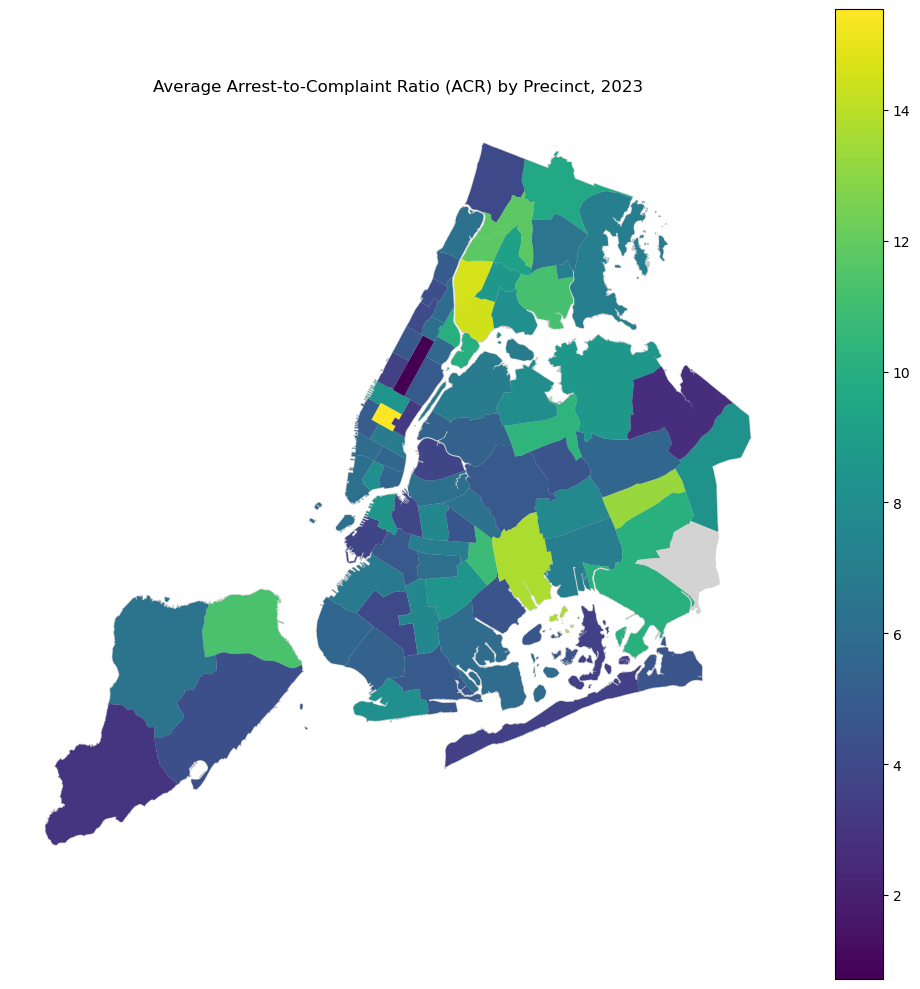

In [5]:
# === Precinct Spatial Mapping & GeoJSON Export ===
# Requires: geopandas, pandas, matplotlib
# If needed: pip install geopandas pyproj shapely fiona rtree

import pandas as pd
import geopandas as gpd
from pathlib import Path

# ---------- paths ----------
OUTDIR = Path("../final/outputs_bias_starter")
PANEL_PRECINCT = OUTDIR / "panel_monthly_precinct2023.csv"   # created earlier
PRECINCT_GEOJSON = "NYC_Police_Precincts_-8413637686511439451.geojson"

# ---------- 1) load precinct monthly panel & filter to your window ----------
prec_m = pd.read_csv(PANEL_PRECINCT, parse_dates=["YM"])
prec_m = prec_m[prec_m["YM"].dt.year == 2023].copy()


prec_agg = (
    prec_m.groupby("PRECINCT", as_index=False)
    .agg(
        months=("YM","nunique"),
        arrests_total=("arrests","sum"),
        complaints_total=("complaints","sum"),
        acr_mean=("ACR","mean"),
        acr_median=("ACR","median")
    )
)

prec = gpd.read_file(PRECINCT_GEOJSON)
# common key names in NYC precinct layers: "Precinct", "precinct", or "pct"
key = None
for cand in ["Precinct","precinct","PCT","pct"]:
    if cand in prec.columns:
        key = cand
        break
if key is None:
    raise ValueError(f"Couldn't find a precinct id column in: {prec.columns.tolist()}")

prec["PRECINCT"] = pd.to_numeric(prec[key], errors="coerce").astype("Int64")

g_merged = prec.merge(prec_agg, on="PRECINCT", how="left")

OUTDIR.mkdir(parents=True, exist_ok=True)
merged_path = OUTDIR / "precinct_metrics.geojson"
# Use EPSG:4326 for broad compatibility
g_merged = g_merged.to_crs(epsg=4326)
g_merged.to_file(merged_path, driver="GeoJSON")
print("Saved:", merged_path)

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,10))
# Plot base polygons (light border)
g_merged.plot(ax=ax, color="white", edgecolor="lightgray")

g_merged.plot(
    ax=ax,
    column="acr_mean",
    legend=True,
    scheme=None,      # (optional) use "Quantiles" via mapclassify for nicer breaks
    missing_kwds={"color":"lightgray", "label":"No data"},
)
ax.set_axis_off()
ax.set_title("Average Arrest-to-Complaint Ratio (ACR) by Precinct, 2023", pad=12)
plt.tight_layout()
plt.show()
